In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings("ignore")

* [Logistic Regression](#Logistic-Regression)
* [Default Example](#Default-Example)

# Logistic Regression

The linear regression in a binary response using multiple predictors:
$$\log\left(\frac{p(X)}{1 - p(X)}\right)= \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p,$$
where $X= (X_1 ,...,X_p )$ are $p$ predictors. Here, the quantity $p(X)/[1−p(X)]$ is called **the odds**, and can take on any value odds between 0 and $\inf$.

The linear regression can be solved for $p(X)$,
$$p(X) =\dfrac{e^{\beta_0 +\beta_1 X_1 +\dots+\beta_p X_p}}{1 + e^{\beta_0 +\beta_1 X_1 +\dots+\beta_p X_p}}.$$

We can use the maximum likelihood method to estimate $\beta_j$ for $j=1,\ldots,p$. 

## Default Example

In [12]:
df = pd.read_csv('Data/Default.csv')
df.head(5)

,Default,Student,Balance,Income
0,No,No,729.526495,44361.62507
1,No,Yes,817.180407,12106.13470
2,No,No,1073.549164,31767.13895
3,No,No,529.250605,35704.49394
4,No,No,785.655883,38463.49588


Dividing the income by 1000.

In [13]:
df['Income']=df['Income']/1000
df.head(5)

,Default,Student,Balance,Income
0,No,No,729.526495,44.361625
1,No,Yes,817.180407,12.106135
2,No,No,1073.549164,31.767139
3,No,No,529.250605,35.704494
4,No,No,785.655883,38.463496


Here, Student status is encoded as a dummy variable as

$$\text{Student}=\begin{cases}
  1, & \mbox{Student},\\
  0, & \mbox{Non-Student}. \\
\end{cases}$$
This means

In [14]:
df2=copy.deepcopy(df)
df2['Default'] = df.Default.factorize()[0]
df2['Student'] = df.Student.factorize()[0]
df2.head(5)

,Default,Student,Balance,Income
0,0,0,729.526495,44.361625
1,0,1,817.180407,12.106135
2,0,0,1073.549164,31.767139
3,0,0,529.250605,35.704494
4,0,0,785.655883,38.463496


The probability of default:

$$p(X) =\dfrac{e^{\beta_0 +\beta_1 \times  \text{Student} +\beta_2 \times  \text{Balance} +\beta_3 \times  \text{Income} }}
{1+e^{\beta_0 +\beta_1 \times  \text{Student} +\beta_2 \times  \text{Balance} +\beta_3 \times  \text{Income} }}.$$ 

In [15]:
formula = 'Default ~ Student + Income + Balance'
model = smf.glm(formula = formula, data=df2, family=sm.families.Binomial())
Results = model.fit()
Results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
Student,-0.6468,0.236,-2.738,0.006,-1.110,-0.184
Income,0.0030,0.008,0.370,0.712,-0.013,0.019
Balance,0.0057,0.000,24.737,0.000,0.005,0.006


For example, consider a student, James, with a credit card balance of $\$1,200$ and an income of $\$30,000$, and a non-student, Robert with the same balance and income. The estimated probability of defaults for these two:

In [16]:
df0=pd.DataFrame({'Student':[1,0],'Income':[40,40],'Balance':[1500,1500]},index=['James', 'Robert'])
df0

,Student,Income,Balance
James,1,40,1500
Robert,0,40,1500


In [17]:
E=np.exp(Results.params['Intercept']+Results.params['Student']*df0['Student']\
+Results.params['Income']*df0['Income']+Results.params['Balance']*df0['Balance'])
P=E/(1+E)
pd.DataFrame(P,columns=['Probability of defaults'])

,Probability of defaults
James,0.057882
Robert,0.104992


This shows that a student tends to have higher default probabilities than a non-student.

Now, consider

In [18]:
df3=copy.deepcopy(df.groupby(['Student','Default']).size().unstack('Default'))
df3

Default,No,Yes
Student,,
No,6850,206
Yes,2817,127


In [19]:
# Students (Balance and Default)
St_Balance = df[df.Student == 'Yes'].Balance.values.reshape(-1,1)
St_Default = df[df.Student == 'Yes'].Default

St_lReg = skl_lm.LogisticRegression(solver='newton-cg')
St_lReg.fit(St_Balance,St_Default)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# non-Students (Balance and Default)
nSt_Balance = df[df.Student == 'No'].Balance.values.reshape(-1,1)
nSt_Default = df[df.Student == 'No'].Default

nSt_lReg = skl_lm.LogisticRegression(solver='newton-cg')
nSt_lReg.fit(nSt_Balance,nSt_Default)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Now the plots

In [21]:
# x-axis for ploting
X= np.arange(df.Balance.min(), df.Balance.max()).reshape(-1,1)
# Probability of defaults (Students and non-Students)
Prop_st = St_lReg.predict_proba(X)
Prop_nst = nSt_lReg.predict_proba(X)

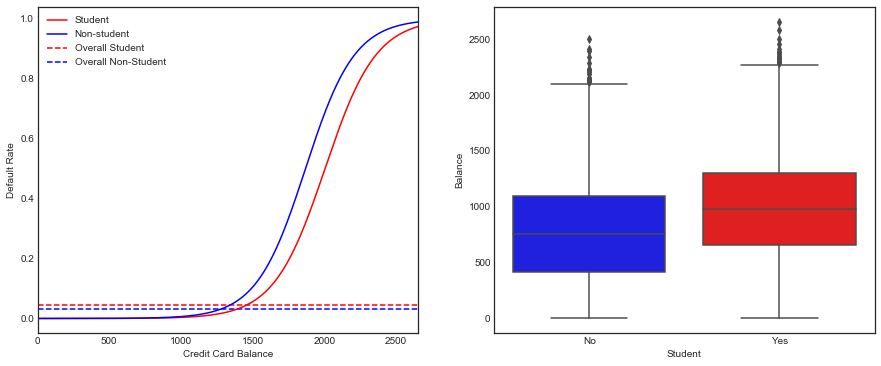

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

# Left plot
ax1.plot(X, Prop_st[:,1], color='Red', label='Student')
ax1.plot(X, Prop_nst[:,1], color='blue', label='Non-student')
# Overall Student
ax1.hlines(df3.loc['Yes','Yes']/df3.loc['Yes','No'], colors='red', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(df3.loc['No','Yes']/df3.loc['No','No'], colors='blue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks(list(np.round(np.linspace(0,1,6),1)))
ax1.set_xlim(X.min(),X.max())
ax1.legend(loc=2)

# Right plot
sns.boxplot('Student', 'Balance', data=df, orient='v', ax=ax2,  palette={'No':'blue', 'Yes':'Red'});

We can see from the left-hand panel graph that students, on the whole, tend to have higher credit card balances means that overall, students tend to default at a higher rate than non-students even though an individual student with a given credit card balance will tend to have a lower probability of default than a non-student with the same credit card balance.

We can see from the left-hand panel graph that students are more likely to have large credit card balances and are ssociated with high default rates.

Students are generally riskier than non-students if no information about the student’s credit card balance is given. Nonetheless, that student is less risky than a non-student with the same credit card balance!

The corrolation matrix:

In [27]:
df2.corr()

,Default,Student,Balance,Income
Default,1.000000,0.035420,0.350119,-0.019871
Student,0.035420,1.000000,0.203578,-0.753985
Balance,0.350119,0.203578,1.000000,-0.152243
Income,-0.019871,-0.753985,-0.152243,1.000000


[None, None, None, None, None, None, None, None]

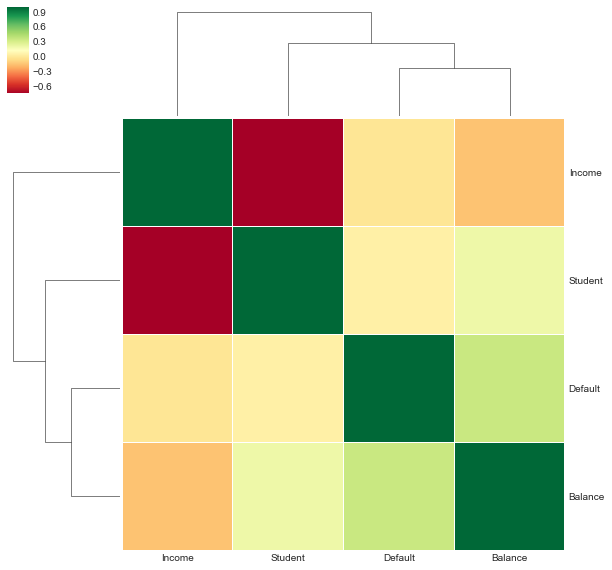

In [44]:
cg = sns.clustermap(df2.corr(), cmap ="RdYlGn", linewidths = 0.5); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 

As can be seen, the variables **Student** and **balance** are correlated and Students have higher values of depts, and the probability of default is higher for students.